In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('sentimentdataset.csv')

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [5]:
df.drop(columns=['Timestamp','User','Platform','Hashtags','Country','Unnamed: 0.1','Unnamed: 0', 'Text'], inplace=True)

In [6]:
df.columns

Index(['Sentiment', 'Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour'], dtype='object')

In [7]:
def hopkins_statistic(X, n_neighbors=10):
    
    m, d = X.shape
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    
    rand_X = np.random.rand(m, d)
    rand_nbrs_dist, _ = nbrs.kneighbors(rand_X, n_neighbors=n_neighbors)
    
    X_nbrs_dist, _ = nbrs.kneighbors(X, n_neighbors=n_neighbors)
    
    num = np.sum(rand_nbrs_dist, axis=1)
    den = np.sum(rand_nbrs_dist + X_nbrs_dist, axis=1)
    
    return np.mean(num / den)

# Drop non-numeric columns if needed
numeric_df = df.select_dtypes(include=['number'])

# Test the dataset for clustering tendency using Hopkins statistic
hopkins_score = hopkins_statistic(numeric_df)
print("Hopkins Statistic:", hopkins_score)


Hopkins Statistic: 0.9975810061662582


In [8]:
# Data preprocessing and PCA
def preprocess_and_pca(df):
    
    # Encode categorical columns
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
        
    # Standardize numerical columns
    scaler = StandardScaler()
    numerical_cols = ['Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Hard-coded PCA transformation
    pca = PCA(n_components=2)

    # Manually select columns for each principal component
    pca_columns = {
        'Engagement_Level': ['Retweets', 'Likes', 'Sentiment'],
        'Temporal_Activity': ['Year', 'Month', 'Day', 'Hour']
    }

    X_pca = pd.DataFrame()

    # Apply PCA separately to each set of columns and combine the results
    for pc, cols in pca_columns.items():
        pca = PCA(n_components=1)
        X_pc = pca.fit_transform(df[cols])
        X_pca[pc] = X_pc.ravel()

    return X_pca



In [9]:
X_pca = preprocess_and_pca(df) 

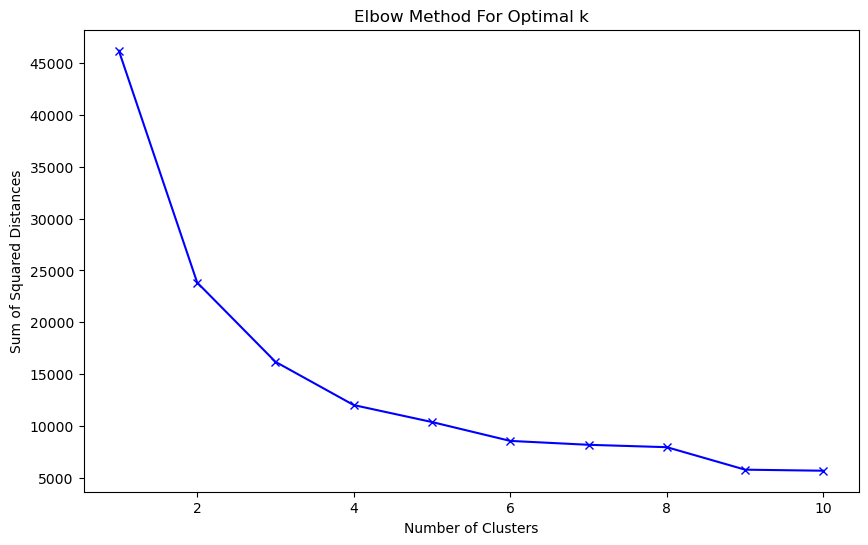

In [10]:
sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X_pca)
    sum_of_squared_distances.append(kmedoids.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
# Instantiate and fit KMedoids
kmedoids = KMedoids(n_clusters=4, random_state=42)

kmedoids.fit(X_pca)

KMedoids(n_clusters=4, random_state=42)

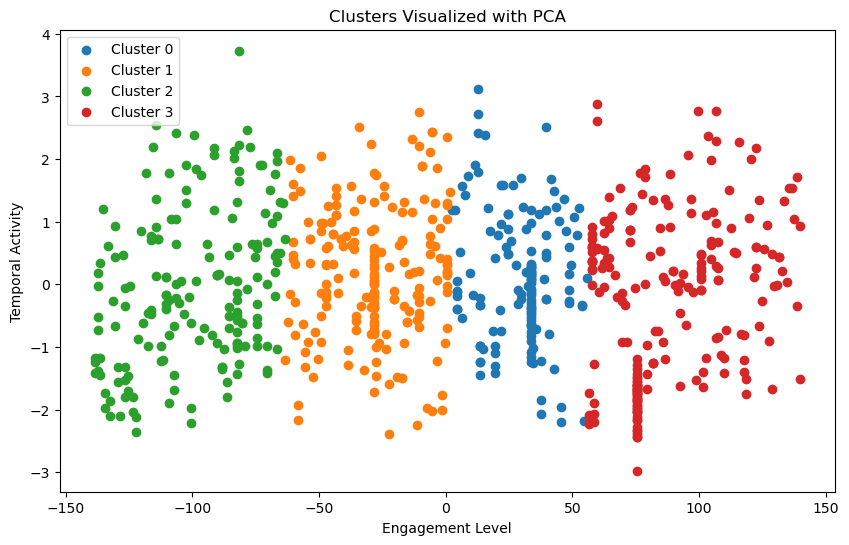

In [12]:
# Get cluster labels
cluster_labels = kmedoids.labels_
# Add cluster labels to DataFrame
df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
for cluster in range(4):
    plt.scatter(X_pca.values[cluster_labels == cluster, 0], X_pca.values[cluster_labels == cluster, 1], label=f'Cluster {cluster}')

plt.title('Clusters Visualized with PCA')
plt.xlabel('Engagement Level')
plt.ylabel('Temporal Activity')
plt.legend()
plt.show()

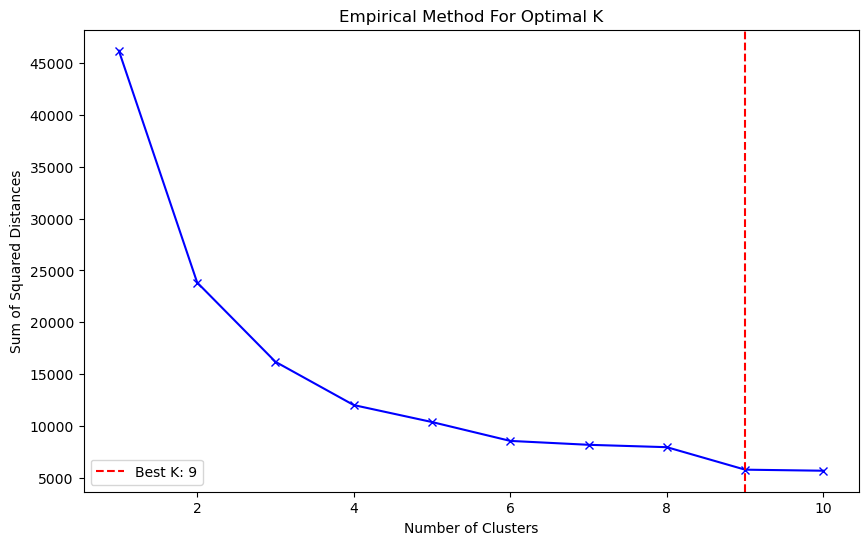

In [13]:
sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X_pca)
    sum_of_squared_distances.append(kmedoids.inertia_)

# Calculate the rate of change
rate_of_change = [sum_of_squared_distances[i] - sum_of_squared_distances[i-1] for i in range(1, len(sum_of_squared_distances))]

# Find the index where the rate of change is highest
best_k_index = rate_of_change.index(max(rate_of_change))

# Best number of clusters
best_k = K[best_k_index]

# Plot the sum of squared distances
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Empirical Method For Optimal K')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K: {best_k}')
plt.legend()
plt.show()


In [14]:
# Instantiate and fit KMedoids
kmedoids = KMedoids(n_clusters=9, random_state=42)
kmedoids.fit(X_pca)


KMedoids(n_clusters=9, random_state=42)

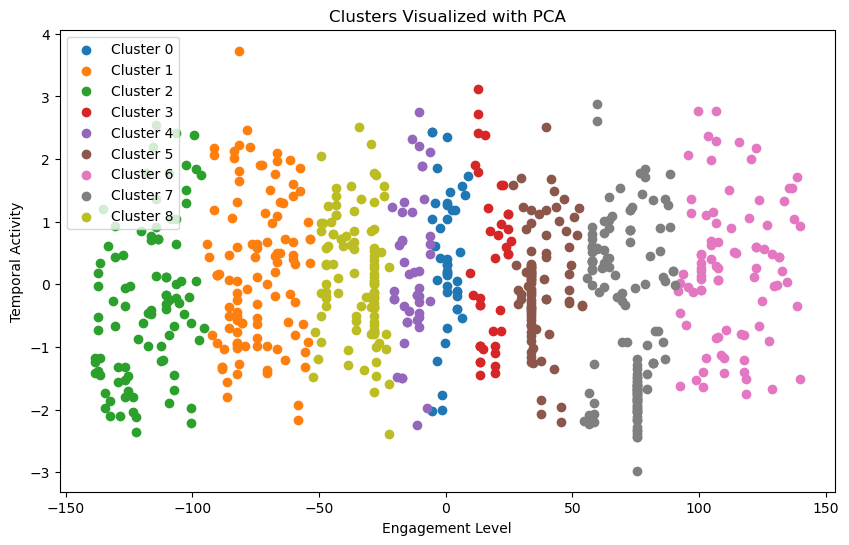

In [15]:
# Get cluster labels
cluster_labels = kmedoids.labels_
# Add cluster labels to DataFrame
df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
for cluster in range(9):
    plt.scatter(X_pca.values[cluster_labels == cluster, 0], X_pca.values[cluster_labels == cluster, 1], label=f'Cluster {cluster}')

plt.title('Clusters Visualized with PCA')
plt.xlabel('Engagement Level')
plt.ylabel('Temporal Activity')
plt.legend()
plt.show()

In [16]:
intra_cluster_distances = []
for cluster in range(9):
    cluster_points = X_pca[cluster_labels == cluster]
    if len(cluster_points) > 1:
        pairwise_dist = pairwise_distances(cluster_points)
        avg_dist = np.mean(pairwise_dist[np.triu_indices(len(cluster_points), k=1)])
        intra_cluster_distances.append(avg_dist)
    else:
        intra_cluster_distances.append(0)

# Print average intra-cluster distance for each cluster
for i, avg_dist in enumerate(intra_cluster_distances):
    print(f"Average Intra-cluster Distance for Cluster {i}: {avg_dist:.2f}")

Average Intra-cluster Distance for Cluster 0: 4.70
Average Intra-cluster Distance for Cluster 1: 13.43
Average Intra-cluster Distance for Cluster 2: 14.71
Average Intra-cluster Distance for Cluster 3: 5.95
Average Intra-cluster Distance for Cluster 4: 5.46
Average Intra-cluster Distance for Cluster 5: 7.03
Average Intra-cluster Distance for Cluster 6: 15.87
Average Intra-cluster Distance for Cluster 7: 10.89
Average Intra-cluster Distance for Cluster 8: 9.95


In [17]:
cluster_labels = kmedoids.labels_
cluster_centroids = kmedoids.cluster_centers_

# Compute pairwise distances between cluster centroids
cluster_distances = pairwise_distances(cluster_centroids)

# Print the pairwise distances
print("Pairwise Distances between Cluster Centroids:")
print(cluster_distances)

Pairwise Distances between Cluster Centroids:
[[  0.          75.00054265 117.00233332  17.0086322   13.00039382
   33.00239901 107.0002902   75.02400725  32.00416097]
 [ 75.00054265   0.          42.00317878  92.00310916  62.00042018
  108.00040198 182.00064741 150.00974425  43.00137411]
 [117.00233332  42.00317878   0.         134.00597125 104.00197584
  150.00031177 224.00142628 192.00330982  85.00025722]
 [ 17.0086322   92.00310916 134.00597125   0.          30.00695553
   16.02842413  90.00232447  58.05194126  49.0113346 ]
 [ 13.00039382  62.00042018 104.00197584  30.00695553   0.
   46.00078274 120.00023776  88.01800723  19.00438285]
 [ 33.00239901 108.00040198 150.00031177  16.02842413  46.00078274
    0.          74.00131969  42.02674961  65.00007138]
 [107.0002902  182.00064741 224.00142628  90.00232447 120.00023776
   74.00131969   0.          32.05588112 139.00118877]
 [ 75.02400725 150.00974425 192.00330982  58.05194126  88.01800723
   42.02674961  32.05588112   0.         

In [18]:
# Calculate Calinski-Harabasz score
calinski_harabasz_Kmedoid = calinski_harabasz_score(X_pca, cluster_labels)

print("Calinski-Harabasz Score:", calinski_harabasz_Kmedoid)

Calinski-Harabasz Score: 5004.573746111793


In [19]:
DBSCANmodel = DBSCAN(eps=3.5, min_samples=11,metric='euclidean' ).fit(X_pca)
labels=DBSCANmodel.labels_

In [20]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_=list(labels).count(-1)
print("Estimated number of clusters:", n_clusters_)
print("Number of noise points:", n_noise_)

Estimated number of clusters: 7
Number of noise points: 18


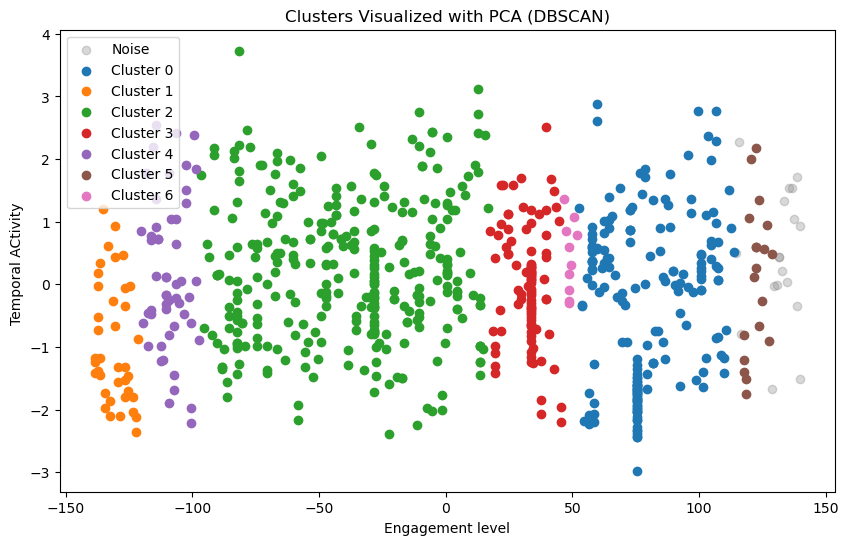

In [21]:
# Plot the clusters with background color for each cluster
plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        # Noise points
        plt.scatter(X_pca.values[labels == label, 0], X_pca.values[labels == label, 1], label='Noise', alpha=0.3, color='gray')
    else:
        plt.scatter(X_pca.values[labels == label, 0], X_pca.values[labels == label, 1], label=f'Cluster {label}')

plt.title('Clusters Visualized with PCA (DBSCAN)')
plt.xlabel('Engagement level')
plt.ylabel('Temporal ACtivity ')
plt.legend()
plt.show()

In [22]:
# Calculate Calinski-Harabasz score
calinski_harabasz_dbScan = calinski_harabasz_score(X_pca, labels)

print("Calinski-Harabasz Score:", calinski_harabasz_dbScan)

Calinski-Harabasz Score: 1003.3005933548242


In [24]:
best_score = max(calinski_harabasz_Kmedoid, calinski_harabasz_dbScan)

if(best_score == calinski_harabasz_Kmedoid):
    print(f"The best model is Kmedoid with score: {best_score}")
else:
    print(f"The best model is dbScan with score: {best_score}")

The best model is Kmedoid with score: 5004.573746111793
